In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


import geopandas as gp
import sys

sys.path.insert(0, "../Notebooks/Functions")
import StatsFunctions as MF

In [3]:
Countries = pd.read_excel(
    "../Data/UNDP data/HDR21-22_Statistical_Annex_HDI_Table.xlsx",
    sheet_name="Table 1",
    header=5,
    usecols="B:C",
    nrows=201,
)

In [4]:
Countries = Countries.dropna().query("Value != '..'")["Country"].reset_index(drop=True)

In [5]:
Rest = pd.read_excel(
    "../Data/UNDP data/HDR21-22_Statistical_Annex_HDI_Table.xlsx",
    sheet_name="Table 1",
    header=4,
    usecols="C,E,G,I,K,M,O",
    nrows=198,
)

In [6]:
Rest = Rest.dropna().drop(index=1, axis=1).reset_index(drop=True)

In [7]:
IQ = pd.read_html("../Data/HTML data/Countries by Average IQ 2023.html")[-1]

In [8]:
combined2 = pd.concat([Countries, Rest], axis=1)

In [9]:
world = gp.read_file(gp.datasets.get_path('naturalearth_lowres'))

C:\Users\dima1\AppData\Local\Temp\ipykernel_45592\2282005331.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gp.read_file(gp.datasets.get_path('naturalearth_lowres'))


In [10]:
combined2["Country"].replace(
    {
        "Viet Nam": "Vietnam",
        "Korea (Republic of)": "South Korea",
        "Türkiye": "Turkey",
        "Russian Federation": "Russia",
        "Iran (Islamic Republic of)": "Iran",
        "Moldova (Republic of)": "Moldova",
        "Palestine, State of": "Palestine",
        "Venezuela (Bolivarian Republic of)": "Venezuela",
        "Bolivia (Plurinational State of)": "Bolivia",
        "Syrian Arab Republic": "Syria",
        "United States": "United States of America",
        "Tanzania (United Republic of)": "Tanzania",
        "Congo (Democratic Republic of the)": "Dem. Rep. Congo"
    },
    inplace=True,
)

IQ["Region"].replace(
    {
        "Czech Republic": "Czechia",
        "Republic of the Congo": "Congo",
        "United States": "United States of America",
        "DR Congo": "Dem. Rep. Congo"
    },
    inplace=True,
)

world["name"].replace(
    {
        "Dominican Rep.":"Dominican Republic",
        "Central African Rep.": "Central African Republic",
        "Bosnia and Herz.": "Bosnia and Herzegovina",
        "S. Sudan": "South Sudan"
    },
    inplace = True
    
)

In [11]:
DF = pd.merge(
    left=IQ, right=combined2, how="outer", left_on="Region", right_on="Country"
)

In [12]:
DF.rename(
    {
        "Human Development Index (HDI) ": "HDI",
        "Life expectancy at birth": "LifeExpectancy",
        "Expected years of schooling": "ExpectedYearsOfScholing",
        "Mean years of schooling": "MeanYearsOfSchooling",
        "Gross national income (GNI) per capita": "GNI",
        "Average IQ": "IQ",
    },
    axis=1,
    inplace=True,
)

In [13]:
DF = DF.astype(
    {
        "HDI": "float",
        "LifeExpectancy": "float",
        "ExpectedYearsOfScholing": "float",
        "MeanYearsOfSchooling": "float",
        "GNI": "float",
        "GNI per capita rank minus HDI rank": "float",
        "HDI rank": "float",
        "IQ": "float",
    }
)

In [14]:
d1 = pd.merge(left = world[["continent", "name", "pop_est", "iso_a3", "geometry"]], right = DF, left_on = "name", right_on="Region")

In [15]:
d2 = pd.merge(left = world[["continent", "name", "pop_est", "iso_a3", "geometry"]], right = DF, left_on = "name", right_on="Country")

In [16]:
DF = pd.merge(d1, d2, how = "outer").dropna()

In [17]:
DF = DF.rename({"continent": "Continent", "pop_est": "Population"}, axis=1)[
    [
        "Continent",
        "Country",
        "iso_a3",
        "geometry",
        "HDI",
        "LifeExpectancy",
        "ExpectedYearsOfScholing",
        "MeanYearsOfSchooling",
        "GNI",
        "IQ"
    ]
]

In [18]:
colours = dict(zip(DF["Continent"].unique(), sns.color_palette("bright", 6)))
kwargs = {"hue": "Continent", "palette": colours, "edgecolor": "black", "alpha": 0.6}

In [19]:
fig = px.choropleth(
    DF,
    locations='iso_a3',
    color='IQ',
    color_continuous_scale='thermal',
    hover_data="Country"
    
)
fig.update_layout(margin={"r":30,"t":50,"l":500,"b":0}, title_text='Average IQ of countries', title_x=0.5, autosize = True)


fig.show()

In [20]:
DF.loc[(DF["Country"] == "Togo") | (DF["Country"] == "Ghana") | (DF["Country"] == "United States of America") , ["Country" ,"Continent", "IQ"]]

,Country,Continent,IQ
3,United States of America,North America,97.43
55,Togo,Africa,59.83
56,Ghana,Africa,58.16


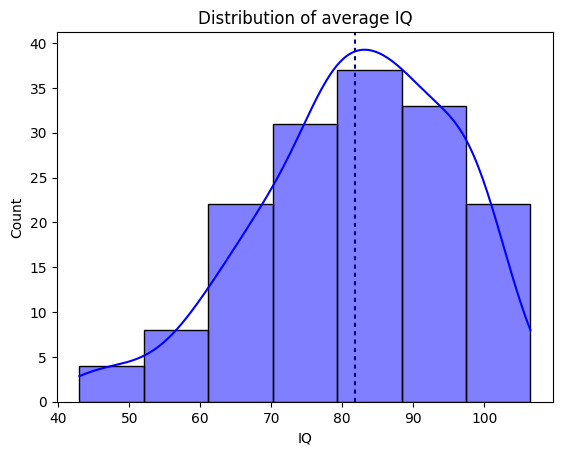

In [21]:
# decided to check average IQ and see how useful it would be
sns.histplot(DF, x="IQ", bins=7, kde=True, color="blue")

plt.axvline(
    MF.mean(DF["IQ"]), color="darkblue", label="mean", dashes=(2, 2)
)  

plt.title("Distribution of average IQ")
plt.show()

In [22]:
pd.DataFrame(DF.sort_values(by = "IQ", ascending=False).head(5))[["Continent", "Country", "IQ"]]

,Continent,Country,IQ
147,Asia,Japan,106.48
131,Asia,China,104.10
89,Asia,South Korea,102.35
104,Europe,Belarus,101.60
143,Europe,Finland,101.20


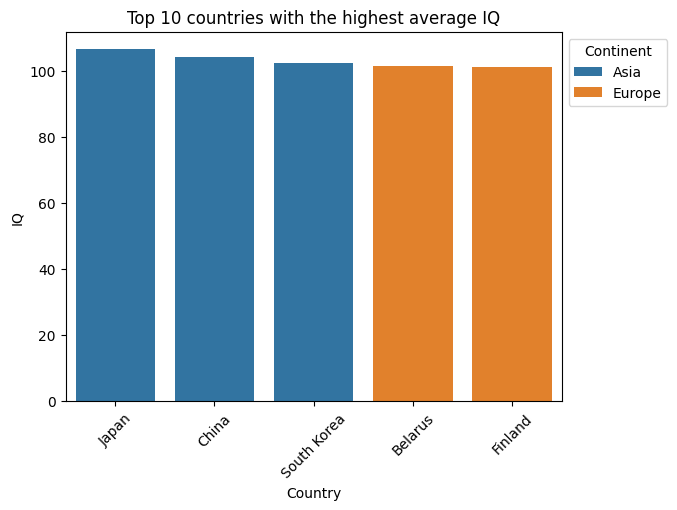

In [23]:
ax = sns.barplot(data = pd.DataFrame(DF.sort_values(by = "IQ", ascending=False).head(5)), x = "Country", hue = "Continent", y = "IQ")
plt.xticks(rotation = 45)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("Top 10 countries with the highest average IQ")
plt.show()

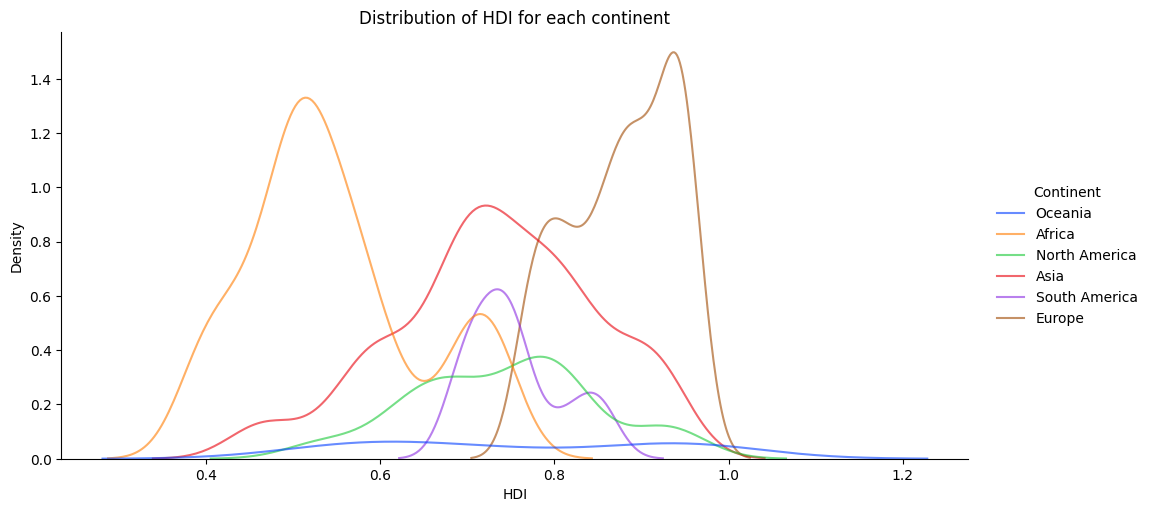

In [24]:
sns.displot(data=DF, x="HDI", **{i:kwargs[i] for i in kwargs if i not in ['edgecolor']}, aspect = 2, kind = "kde", bw_adjust=0.7)

plt.title("Distribution of HDI for each continent")
plt.show()

Text(0.5, 1.0, 'Distribution of IQ for each continent')

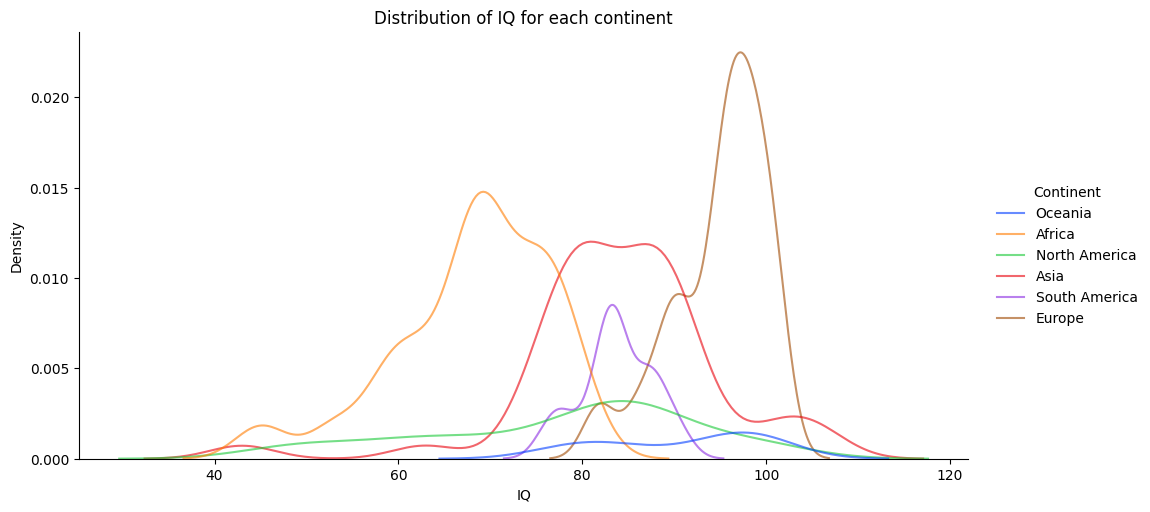

In [25]:
sns.displot(data=DF, x="IQ", **{i:kwargs[i] for i in kwargs if i not in ['edgecolor']}, aspect = 2, kind = "kde", bw_adjust=0.7)

plt.title("Distribution of IQ for each continent")

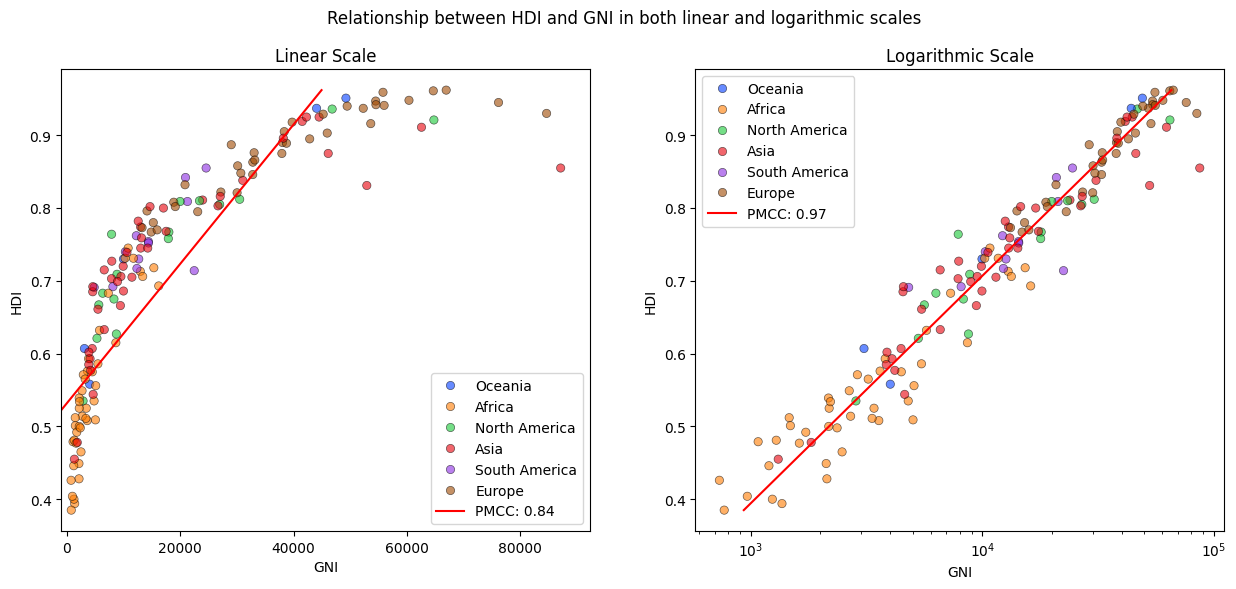

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
m,q, cor = MF.linear_regression(DF["HDI"].to_list(), DF["GNI"].to_list())
m1,q1, cor1 = MF.linear_regression(DF["HDI"].to_list(), np.log10(DF["GNI"].to_list()))
sns.scatterplot(data=DF, x="GNI", y="HDI", **kwargs, ax = axes[0], )  
sns.lineplot(y = DF["HDI"], x = m*DF["HDI"] + q , label = f'PMCC: {round(cor, 2)}', color = "red", ax = axes[0])
axes[0].set_title("Linear Scale")
axes[0].set_xlim((-1000, None))
###
axes[1].set_xscale('log')
X = np.column_stack((np.ones_like(DF["HDI"]), DF["HDI"]))
y_log = np.log(DF["GNI"])
theta = np.linalg.inv(X.T @ X) @ X.T @ y_log
# Predict y values using the linear regression model
y_pred_log = X @ theta

# Plot the linear regression line
sns.scatterplot(data=DF, x="GNI", y="HDI", **kwargs, ax = axes[1])  
sns.lineplot(y = DF["HDI"], x = np.exp(y_pred_log) , label = f'PMCC: {round(cor1, 2)}', color = "red", ax = axes[1])
axes[1].set_title("Logarithmic Scale")

fig.suptitle('Relationship between HDI and GNI in both linear and logarithmic scales')

#more the country invests in people -> they tend to earn and save more money
plt.show()

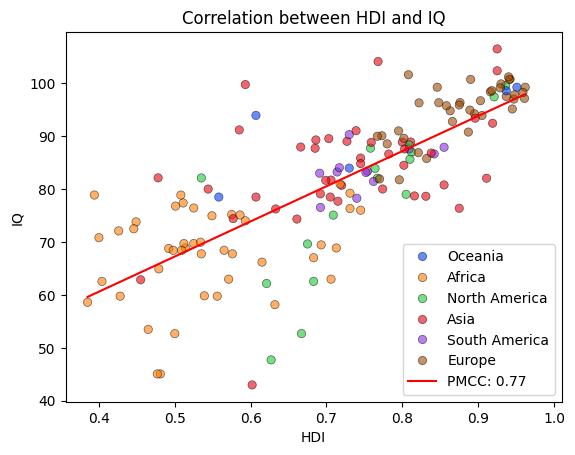

In [27]:
fig, ax = plt.subplots()
m,q, cor = MF.linear_regression(DF["HDI"].to_list(), DF["IQ"].to_list())

sns.scatterplot(data = DF, x = "HDI", y = "IQ", **kwargs)
sns.lineplot(x = DF["HDI"], y = m*DF["HDI"] + q , label = f'PMCC: {round(cor, 2)}', color = "red", ax = ax)
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("Correlation between HDI and IQ")
plt.xlim((None, 1.01))
plt.show()

In [28]:
DF["SchoolingDifference"] = DF["ExpectedYearsOfScholing"] - DF["MeanYearsOfSchooling"]

In [29]:
Continents = DF.groupby("Continent").agg(
    {
        "LifeExpectancy": MF.mean,
        "ExpectedYearsOfScholing": MF.mean,
        "MeanYearsOfSchooling": MF.mean,
        "GNI": "sum",
    }
)

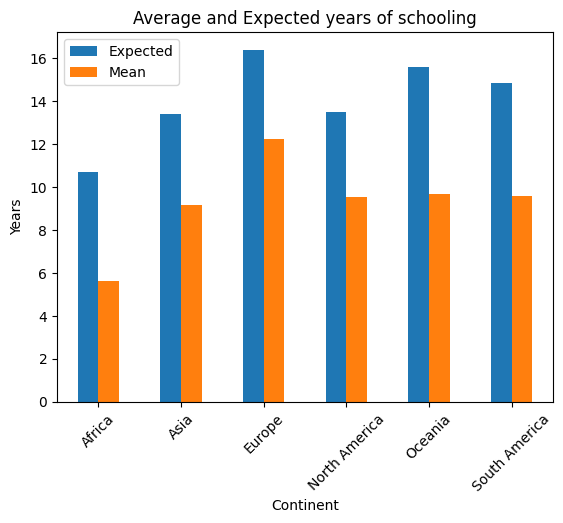

In [30]:
fig, ax = plt.subplots()
Continents.plot.bar(y = ["ExpectedYearsOfScholing", "MeanYearsOfSchooling"], ax = ax)
plt.xticks(rotation = 45)
plt.ylabel("Years")
plt.title("Average and Expected years of schooling")
ax.legend(["Expected", "Mean"])
plt.show()

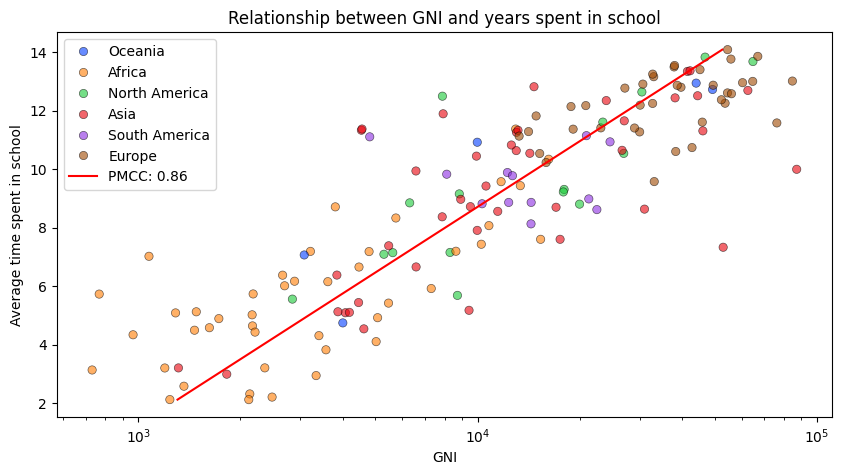

In [48]:
fig, ax = plt.subplots(figsize = (10,5))
sns.scatterplot(data = DF, x = "GNI", y = "MeanYearsOfSchooling", **kwargs, ax = ax)
plt.title("Relationship between GNI and years spent in school")
plt.xscale("log")

m1,q1, cor1 = MF.linear_regression(DF["MeanYearsOfSchooling"].to_list(), np.log10(DF["GNI"].to_list()))


X = np.column_stack((np.ones_like(DF["MeanYearsOfSchooling"]), DF["MeanYearsOfSchooling"]))
y_log = np.log(DF["GNI"])
theta = np.linalg.inv(X.T @ X) @ X.T @ y_log
# Predict y values using the linear regression model
y_pred_log = X @ theta

sns.lineplot(x =np.exp(y_pred_log), y = DF["MeanYearsOfSchooling"], color='red',  label = f'PMCC: {round(cor1, 2)}', ax = ax)

# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

ax.set_ylabel("Average time spent in school")

plt.show()

<Axes: xlabel='LifeExpectancy', ylabel='IQ'>

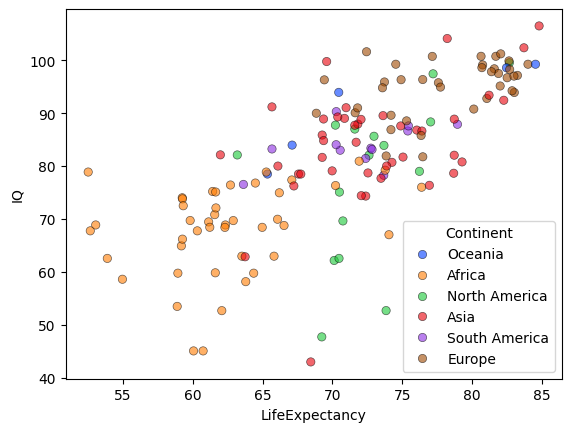

In [32]:
sns.scatterplot(data = DF, x = "LifeExpectancy", y = "IQ", **kwargs)

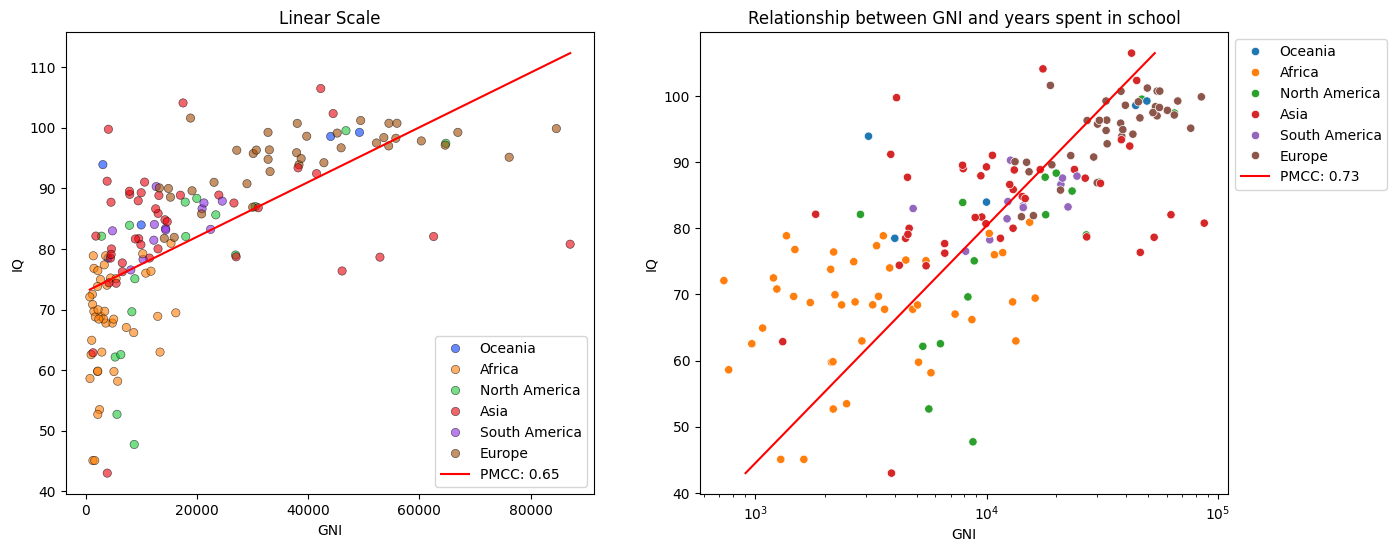

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))



m,q, cor = MF.linear_regression(DF["GNI"].to_list(), DF["IQ"].to_list())
sns.scatterplot(data =DF, y="IQ", x="GNI", **kwargs, ax = axes[0])  
sns.lineplot(x = DF["GNI"], y = m*DF["GNI"] + q , label = f'PMCC: {round(cor, 2)}', color = "red", ax = axes[0])
axes[0].set_title("Linear Scale")



sns.scatterplot(data = DF, x = "GNI", y = "IQ", hue = "Continent", ax = axes[1])
plt.title("Relationship between GNI and years spent in school")
axes[1].set_xscale('log')  # Set x-axis to log scale

m1,q1, cor1 = MF.linear_regression(DF["IQ"].to_list(), np.log10(DF["GNI"].to_list()))


X = np.column_stack((np.ones_like(DF["IQ"]), DF["IQ"]))
y_log = np.log(DF["GNI"])
theta = np.linalg.inv(X.T @ X) @ X.T @ y_log
# Predict y values using the linear regression model
y_pred_log = X @ theta

sns.lineplot(x = np.exp(y_pred_log), y = DF["IQ"], color='red',  label = f'PMCC: {round(cor1, 2)}', ax = axes[1])

sns.move_legend(axes[1], "upper left", bbox_to_anchor=(1, 1))


plt.show()

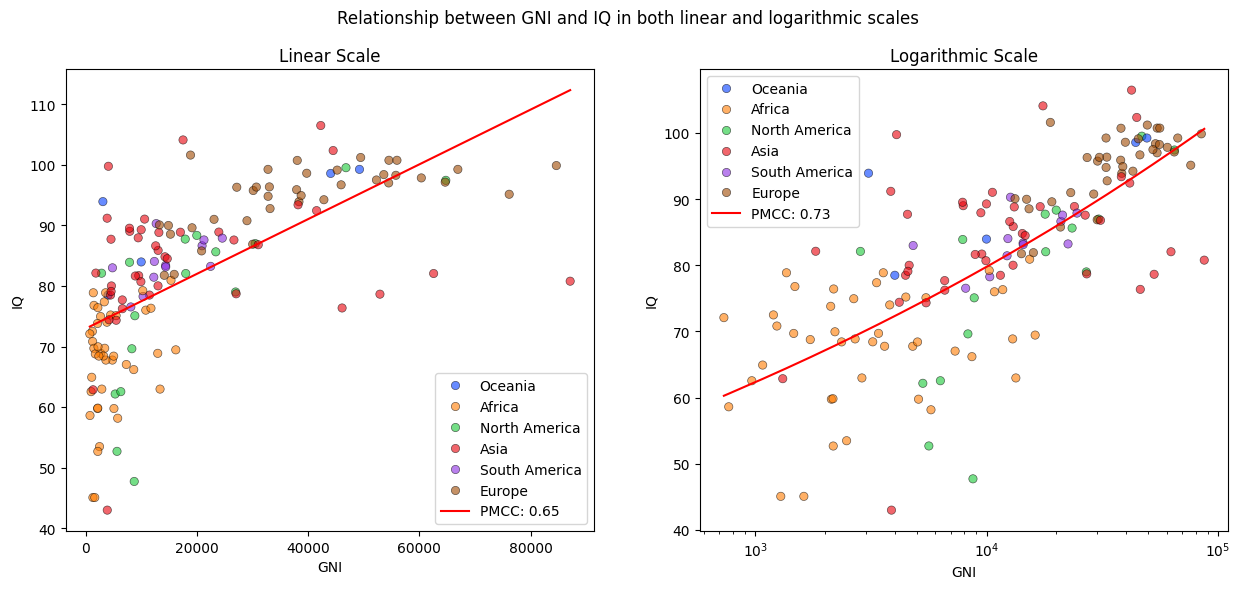

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
m,q, cor = MF.linear_regression(DF["GNI"].to_list(), DF["IQ"].to_list())
sns.scatterplot(data    =DF, y="IQ", x="GNI", **kwargs, ax = axes[0])  
sns.lineplot(x = DF["GNI"], y = m*DF["GNI"] + q , label = f'PMCC: {round(cor, 2)}', color = "red", ax = axes[0])
axes[0].set_title("Linear Scale")



###

m1,q1, cor1 = MF.linear_regression(DF["IQ"].to_list(), np.log10(DF["GNI"].to_list()))
axes[1].set_xscale('log')  # Set x-axis to log scale
X_log = np.column_stack((np.ones_like(np.log(DF["GNI"])), np.log(DF["GNI"])))
y_log = np.log(DF["IQ"])
theta = np.linalg.inv(X_log.T @ X_log) @ X_log.T @ y_log
y_pred_log = X_log @ theta


# Plot the linear regression line
sns.scatterplot(data=DF, y="IQ", x="GNI", **kwargs, ax = axes[1])  
sns.lineplot(x = DF["GNI"], y =np.exp(y_pred_log), color='red',  label = f'PMCC: {round(cor1, 2)}', ax = axes[1])

axes[1].set_title("Logarithmic Scale")

fig.suptitle('Relationship between GNI and IQ in both linear and logarithmic scales')

#more money -> access to education -> smarter on average
plt.show()

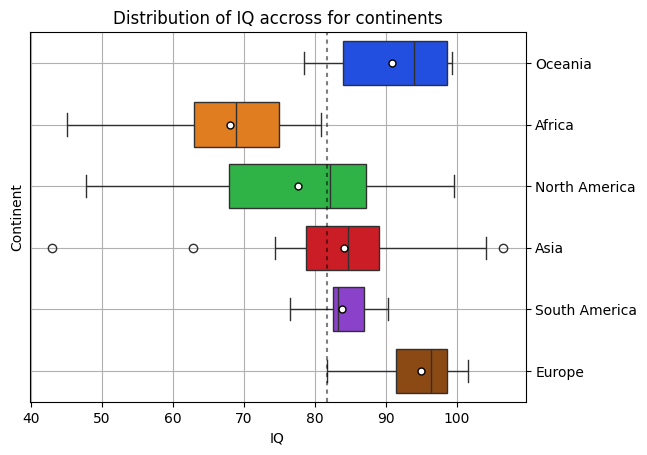

In [35]:
ax = sns.boxplot(
    data=DF,
    x="IQ",
    y="Continent",
    gap=0.4,
    **{i: kwargs[i] for i in kwargs if i not in ["edgecolor", "alpha"]},
    legend="auto",
    width=1.2,
    showmeans=True,
    meanprops={
        "marker": "o",
        "markerfacecolor": "white",
        "markeredgecolor": "black",
        "markersize": "5",
    }
)

plt.axvline(
    x=MF.mean(DF["IQ"]),
    color="black",
    alpha=0.5,
    dashes=(2, 2),
)
ax.grid()
# ax.tick_params(axis="y", rotation=45, )
ax.yaxis.tick_right()


plt.title("Distribution of IQ accross for continents")
plt.show()

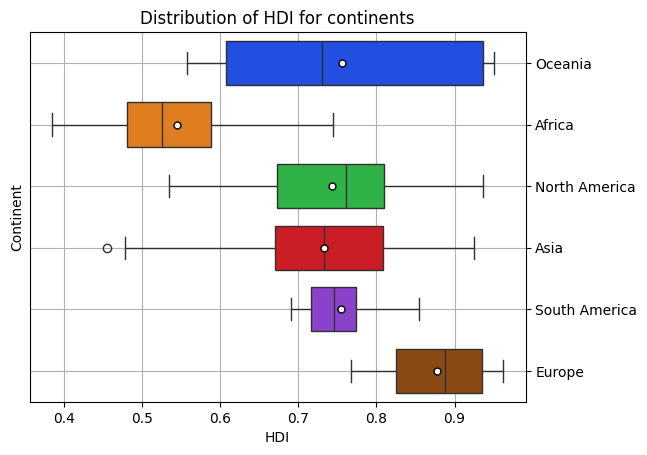

In [36]:
ax = sns.boxplot(
    data=DF,
    x="HDI",
    y="Continent",
    gap=0.4,
    **{i: kwargs[i] for i in kwargs if i not in ["edgecolor", "alpha"]},
    legend="auto",
    width=1.2,
    showmeans=True,
    meanprops={
        "marker": "o",
        "markerfacecolor": "white",
        "markeredgecolor": "black",
        "markersize": "5",
    }
)

ax.grid()
# ax.tick_params(axis="y", rotation=45, )
ax.yaxis.tick_right()


plt.title("Distribution of HDI for continents")
plt.show()

Text(0.5, 1.0, 'Distribution of GNI accross for continents')

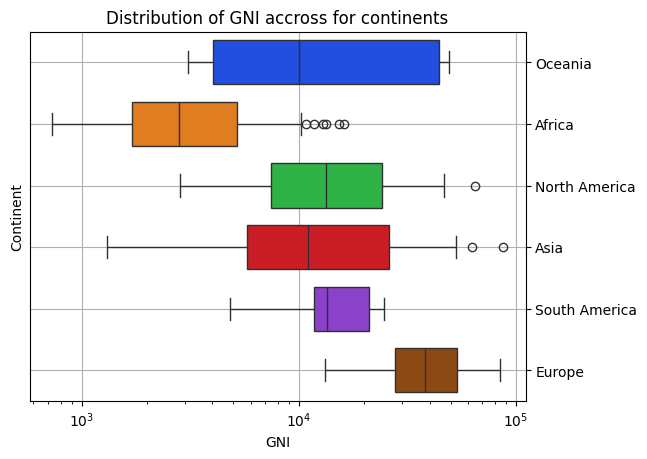

In [37]:
ax = sns.boxplot(
    data=DF,
    x="GNI",
    y="Continent",
    gap=0.4,
    **{i: kwargs[i] for i in kwargs if i not in ["edgecolor", "alpha"]},
    legend="auto",
    width=1.2
)

ax.grid()
ax.yaxis.tick_right()
ax.set_xscale("log")


plt.title("Distribution of GNI accross for continents")

Text(0.5, 1.0, 'Distribution of GNI accross for continents')

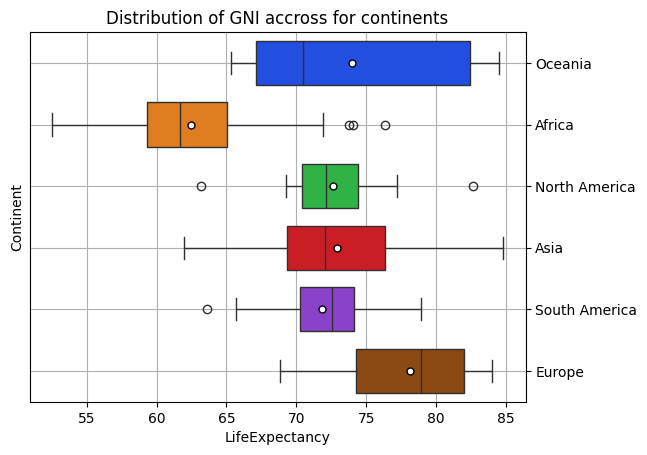

In [38]:
ax = sns.boxplot(
    data=DF,
    x="LifeExpectancy",
    y="Continent",
    gap=0.4,
    **{i: kwargs[i] for i in kwargs if i not in ["edgecolor", "alpha"]},
    legend="auto",
    width=1.2,
    showmeans=True,
    meanprops={
        "marker": "o",
        "markerfacecolor": "white",
        "markeredgecolor": "black",
        "markersize": "5",
    }
)

ax.grid()
ax.yaxis.tick_right()


plt.title("Distribution of GNI accross for continents")#

##repeats the same pattern -> practically the same -> scatter of life and IQ

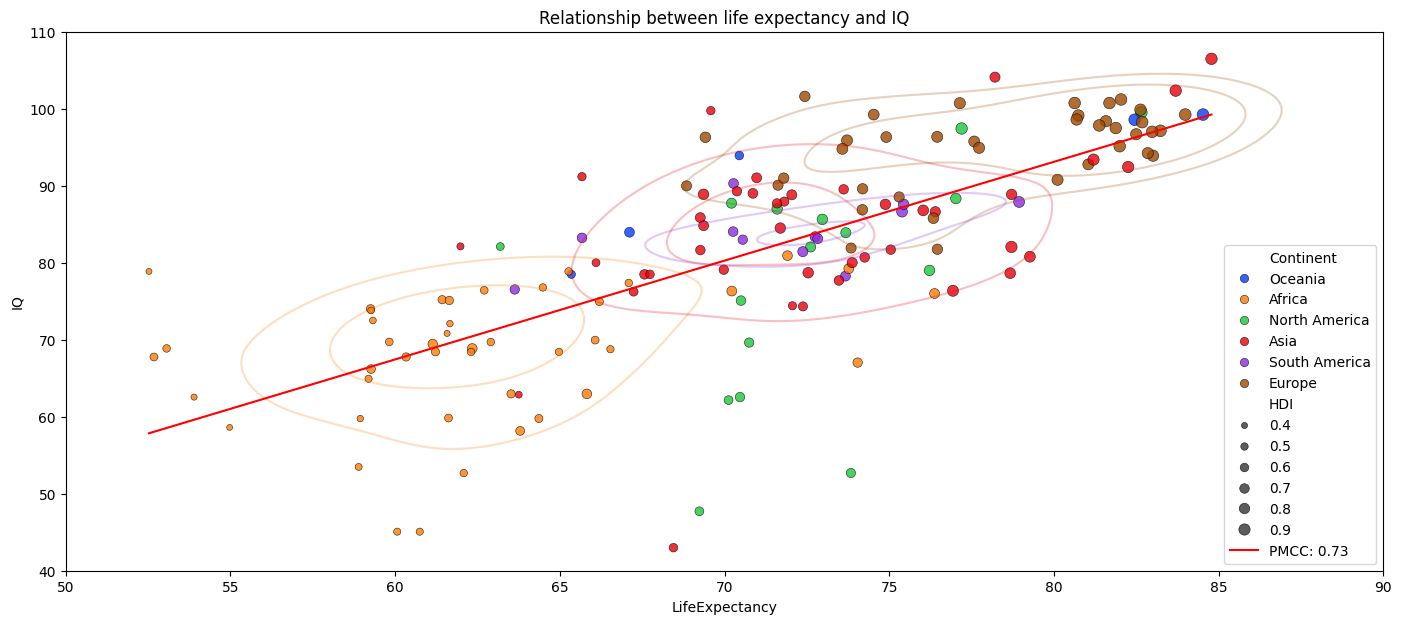

In [39]:
fig, ax = plt.subplots(figsize=(17, 7))

m,q, cor = MF.linear_regression(DF["LifeExpectancy"].to_list(), DF["IQ"].to_list())
sns.scatterplot(data=DF, x="LifeExpectancy", y="IQ", **{i: kwargs[i] for i in kwargs if i not in ["alpha"]}, alpha = 0.8, size = "HDI" ,ax = ax)
sns.kdeplot(
    data=DF,
    x="LifeExpectancy",
    y="IQ",
    **{i: kwargs[i] for i in kwargs if i not in ["edgecolor", "alpha"]},
    levels=3,
    thresh=0.4,
    alpha=0.25
)
sns.lineplot(x = DF["LifeExpectancy"], y = m*DF["LifeExpectancy"] + q , label = f'PMCC: {round(cor, 2)}', color = "red", ax = ax)

sns.move_legend(ax, "lower right")
ax.set_xlim((50, 90))
ax.set_ylim((40, 110))
plt.title("Relationship between life expectancy and IQ")

#analyse clusters and their location on the map -> why low GNI?

plt.show()

In [50]:
DF.query("Continent == 'Africa'").sort_values(by = "GNI", ascending=False)

,Continent,Country,iso_a3,geometry,HDI,LifeExpectancy,ExpectedYearsOfScholing,MeanYearsOfSchooling,GNI,IQ,SchoolingDifference
46,Africa,Botswana,BWA,"POLYGON ((29.43219 -22.09131, 28.01724 -22.827...",0.693,61.1409,12.265138,10.340000,16198.318410,69.45,1.925138
154,Africa,Libya,LBY,"POLYGON ((25.00000 22.00000, 25.00000 20.00304...",0.718,71.9112,12.854280,7.599985,15335.712000,80.92,5.254295
63,Africa,Gabon,GAB,"POLYGON ((11.27645 2.26105, 11.75167 2.32676, ...",0.706,65.8210,12.977310,9.436000,13366.934550,62.97,3.541310
22,Africa,South Africa,ZAF,"POLYGON ((16.34498 -28.57671, 16.82402 -28.082...",0.713,62.3410,13.643710,11.373160,12948.373250,68.87,2.270550
153,Africa,Egypt,EGY,"POLYGON ((36.86623 22.00000, 32.90000 22.00000...",0.731,70.2207,13.786500,9.573026,11731.690560,76.32,4.213474
75,Africa,Algeria,DZA,"POLYGON ((-8.68440 27.39574, -8.66512 27.58948...",0.745,76.3767,14.626896,8.069284,10800.225460,76.00,6.557612
74,Africa,Tunisia,TUN,"POLYGON ((9.48214 30.30756, 9.05560 32.10269, ...",0.731,73.7719,15.425382,7.431599,10257.544770,79.22,7.993784
47,Africa,Namibia,NAM,"POLYGON ((19.89577 -24.76779, 19.89473 -28.461...",0.615,59.2690,11.927207,7.192013,8633.504452,66.19,4.735194
152,Africa,Morocco,MAR,"POLYGON ((-2.16991 35.16840, -1.79299 34.52792...",0.683,74.0419,14.151910,5.916000,7302.819170,67.03,8.235910
56,Africa,Ghana,GHA,"POLYGON ((0.02380 11.01868, -0.04978 10.70692,...",0.632,63.7954,12.047780,8.329887,5744.504017,58.16,3.717893


In [40]:
fig = px.choropleth(
    DF,
    locations='iso_a3',
    color='LifeExpectancy',
    color_continuous_scale='thermal',
    hover_data="Country"
    
)
fig.update_layout(margin={"r":30,"t":50,"l":500,"b":0}, title_text='Average IQ of countries', title_x=0.5, autosize = True)


fig.show()